# Predicting Organic Product Purchases Using Customer Loyalty Data

## 1. Problem Definition

The supermarket is introducing a new line of organic products and wishes to understand which customers are most likely to purchase them. As marketing campaigns can be costly, the business objective is to target promotions effectively, focusing on customers with a higher likelihood of purchasing organic products.

This problem is formulated as a binary classification task, where the goal is to predict whether a customer will purchase organic products based on demographic, behavioural, and loyalty-related attributes.

Target variable: ORGYN

1 = Customer purchased organic products

0 = Customer did not purchase organic products

The results of this analysis can support data-driven decision-making for targeted marketing strategies, helping to maximise conversion rates while reducing unnecessary promotional spend.

In [41]:
import pandas as pd
import numpy as np

from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report, 
    confusion_matrix, roc_curve, roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier

import joblib

pd.set_option("display.max_columns", None)


## 2. Data Overview

The ORGANICS dataset contains customer-level data collected from a supermarket
loyalty programme. It includes demographic variables, purchase behaviour,
affluence indicators, and loyalty status.

The target variable is ORGYN, indicating whether a customer purchased organic
products.


In [2]:
# import the dataset
df = pd.read_csv("organics.csv")

df.shape

(22223, 18)

In [3]:
df.head()

,CUSTID,GENDER,DOB,EDATE,AGE,AGEGRP1,AGEGRP2,TV_REG,NGROUP,NEIGHBORHOOD,LCDATE,ORGANICS,BILL,REGION,CLASS,ORGYN,AFFL,LTIME
0,140,U,16/09/21,23/02/98,76,60-80,70-80,Wales & West,C,16.0,07/11/94,0,16000.00,Midlands,Gold,0,10,4
1,620,U,12/02/49,23/02/98,49,40-60,40-50,Wales & West,D,35.0,04/06/93,0,6000.00,Midlands,Gold,0,4,5
2,868,F,27/11/27,23/02/98,70,60-80,70-80,Wales & West,D,27.0,02/08/90,1,0.02,Midlands,Silver,1,5,8
3,1120,M,10/04/32,23/02/98,65,60-80,60-70,Midlands,F,51.0,01/07/91,1,0.01,Midlands,Tin,1,10,7
4,2313,F,21/05/29,23/02/98,68,60-80,60-70,Midlands,A,4.0,01/03/90,0,0.01,Midlands,Tin,0,11,8


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22223 entries, 0 to 22222
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CUSTID        22223 non-null  int64  
 1   GENDER        19711 non-null  object 
 2   DOB           22223 non-null  object 
 3   EDATE         22223 non-null  object 
 4   AGE           22223 non-null  object 
 5   AGEGRP1       20715 non-null  object 
 6   AGEGRP2       20715 non-null  object 
 7   TV_REG        21758 non-null  object 
 8   NGROUP        21549 non-null  object 
 9   NEIGHBORHOOD  21549 non-null  float64
 10  LCDATE        22223 non-null  object 
 11  ORGANICS      22223 non-null  int64  
 12  BILL          22223 non-null  float64
 13  REGION        21758 non-null  object 
 14  CLASS         22223 non-null  object 
 15  ORGYN         22223 non-null  int64  
 16  AFFL          22223 non-null  object 
 17  LTIME         22223 non-null  object 
dtypes: float64(2), int64(3), o

In [5]:
df.isnull().sum()

CUSTID             0
GENDER          2512
DOB                0
EDATE              0
AGE                0
AGEGRP1         1508
AGEGRP2         1508
TV_REG           465
NGROUP           674
NEIGHBORHOOD     674
LCDATE             0
ORGANICS           0
BILL               0
REGION           465
CLASS              0
ORGYN              0
AFFL               0
LTIME              0
dtype: int64

## 3. Exploratory Data Analysis (EDA)

### 3.1 Dataset Overview

The dataset contains approximately 20,000 customer records from a supermarket loyalty program.
The objective is to predict whether a customer purchased organic products (ORGYN), a binary target variable.

Each row represents a unique customer, with demographic, geographic, loyalty, and purchasing information.

Before modelling, an exploratory analysis is conducted to:

understand the target distribution

identify potential data leakage

detect redundant or non-informative features

inform feature selection decisions

### 3.2 Target Variable Distribution

In [6]:
df["ORGYN"].value_counts(normalize=True)

ORGYN
0    0.752284
1    0.247716
Name: proportion, dtype: float64

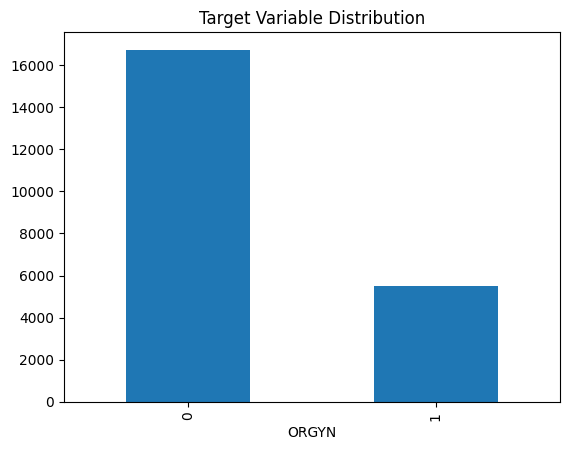

In [7]:
df["ORGYN"].value_counts().plot(kind="bar", title="Target Variable Distribution")
plt.show()

The target variable is imbalanced, with a majority of customers not purchasing organic products.

This imbalance must be considered during model evaluation, making metrics such as precision, recall, F1-score and ROC-AUC more informative than accuracy alone.

### 3.3 Data Profiling (ydata-profiling)

A profiling report was generated using ydata-profiling to obtain a high-level overview of:

- missing values
- variable distributions
- correlations
- potential data quality issues

In [ ]:
profile = ProfileReport(df, explorative=True)
profile.to_file("df.organics-ydata-profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:04<00:00,  4.34it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

: 

: 

### 3.4 Key Findings from EDA

Based on the exploratory analysis, the following key findings were identified:

- The target variable ORGYN is imbalanced, requiring careful model evaluation.
- ORGANICS is a leakage variable and must be excluded from modelling.
- Multiple age-related variables encode the same information and should be reduced to a single feature.
- Geographic variables contain overlapping information.
- EDATE is constant and provides no value.
- CUSTID is an identifier and should not be used as a predictor.

These findings directly inform the data preparation and feature engineering steps that follow.

## 4. Data Preparation and Feature Engineering

### 4.1 Feature Selection and Removal

Based on the findings from the exploratory analysis, the following variables are removed prior to modelling:

ORGANICS → data leakage

CUSTID → identifier only

EDATE → constant value

Redundant age and geographic features

In [8]:
cols_to_drop = [
    "ORGANICS",   # data leakage
    "CUSTID",     # identifier
    "EDATE",      # constant
    "AGE",        # redundant
    "AGEGRP1",    # redundant
    "TV_REG"      # redundant geographic feature
]

df_model = df.drop(columns=cols_to_drop)

Removing these variables:
- prevents leakage
- reduces multicollinearity
- simplifies model interpretation
- improves generalisation

### 4.2 Target and Feature Separation

In [9]:
X = df_model.drop("ORGYN", axis=1)
y = df_model["ORGYN"]

The target variable is kept separate to avoid accidental leakage during preprocessing.

### 4.3 Handling Missing Values

First, missing values are inspected:

In [10]:
X.isnull().sum().sort_values(ascending=False)

GENDER          2512
AGEGRP2         1508
NGROUP           674
NEIGHBORHOOD     674
REGION           465
DOB                0
LCDATE             0
BILL               0
CLASS              0
AFFL               0
LTIME              0
dtype: int64

Strategy: 
- Numerical features --> median imputation (robust to outliers)
- Categorical features -->  most frequent value

This approach avoids data loss while remaining simple and interpretable.

### 4.4 Identifying Feature Types

In [11]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

# print(numeric_features)
# print(categorical_features)

### 4.5 Preprocessing Pipeline

A preprocessing pipeline is created to:
- impute missing values
- encode categorical variables
- scale numerical features

This ensures reproducibility, no data leakage, and compatibility across multiple models.

In [12]:
# Define a pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),          # Impute missing values using the median (robust to outliers)
    ("scaler", StandardScaler())                            # Scale features to have mean=0 and std=1 for better model performance
])

# Define a pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),       # Impute missing values using the most frequent category
    # Encode categorical variables using one-hot encoding 
    ("encoder", OneHotEncoder(handle_unknown="ignore"))         # handle_unknown="ignore" ensures new categories in test data do not break the pipeline
])                                                              

# Combine numeric and categorical transformers into a single preprocessing step
preprocessor = ColumnTransformer(                                   # ColumnTransformer applies appropriate preprocessing to each type of feature
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

This pipeline allows the same preprocessing steps to be reused consistently across all classification models.

### 4.6 Train–Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
test_size=0.25,             # A 75/25 split balances training data availability with robust evaluation
    random_state=42,
    stratify=y              # Stratification preserves the target imbalance 
)

#### Note on class imbalance:
We preserve the target class distribution in the train/test split. This ensures evaluation metrics reflect real-world performance.
If needed, techniques like SMOTE can be applied later, but only on the training set.

## 5. Predictive Modelling and Model Evaluation

The objective of this section is to build and compare multiple machine learning models to predict whether a customer will purchase organic products (ORGYN).

Three different model families were selected to provide a balanced comparison:

- Random Forest – robust, interpretable ensemble method

- XGBoost – high-performance gradient boosting algorithm

- Neural Network – non-linear model capable of learning complex relationships

All models were trained using the same preprocessing pipeline and evaluated on the same hold-out test set to ensure a fair comparison.

### 5.1 Model Selection and Hyperparameter Search Design

This subsection defines the machine learning models used in the analysis along with their associated hyperparameter grids.
Hyperparameter tuning is performed using GridSearchCV to systematically explore model configurations and identify the optimal setup for each algorithm.

In [14]:
# A dictionary of models to be trained and compared.
# Using a dictionary allows us to loop over models instead of repeating code.
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,            # Disable deprecated label encoder
        eval_metric='logloss',              # Explicit evaluation metric
        random_state=42
    ),
    "NeuralNetwork": MLPClassifier(
        max_iter=500,                       # Increase iterations to ensure convergence
        random_state=42
    )
}

# Hyperparameter grids for each model.
# These define the combinations tested by GridSearchCV.
param_grids = {
    "RandomForest": {
        "n_estimators": [100, 200],                 # Number of trees in the forest
        "max_depth": [None, 5, 10]                  # Controls tree complexity
    },
    "XGBoost": {
        "n_estimators": [100, 200],                 # Number of boosting rounds
        "max_depth": [3, 5],                        # Tree depth
        "learning_rate": [0.01, 0.1]                # Step size shrinkage
    },
    "NeuralNetwork": {
        "hidden_layer_sizes": [(50,), (100,)],      # Size of hidden layers
        "alpha": [0.0001, 0.001]                    # Regularisation strength
    }
}

### 5.2 Model Training and Hyperparameter Optimisation Using Cross-Validation

In this step, each model is trained within a unified preprocessing–modelling pipeline.
A loop-based approach is used to avoid code repetition and to ensure all models are trained and tuned using identical procedures.

Five-fold cross-validation is applied during GridSearch to improve robustness and reduce the risk of overfitting.

In [21]:
# Dictionary to store results for later comparison
results = {}

# Dictionary to store trained best models
best_models = {}

# Iterate through each model
for name in models:
    print(f"--- {name} ---")
    
    # Create a pipeline combining preprocessing and the model
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", models[name])
    ])
    
    # GridSearchCV for hyperparameter tuning
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid={
            "classifier__" + k: v
            for k, v in param_grids[name].items()
        },
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )
    
    # Train model
    grid.fit(X_train, y_train)
    
    # Best trained pipeline
    best_model = grid.best_estimator_
    
    # Save trained model to disk
    model_filename = f"best_model_{name}.joblib"
    joblib.dump(best_model, model_filename)
    
    # Store model in memory as well
    best_models[name] = best_model
    
    # Store results
    results[name] = {
    "model_name": name,
    "best_params": grid.best_params_,
    "train_score": grid.best_score_,
    "test_score": best_model.score(X_test, y_test)
    }   

--- RandomForest ---
--- XGBoost ---


c:\Users\FiercePC\anaconda3\envs\adl_tf_gpu_ENV\lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- NeuralNetwork ---


In [22]:
# Save results in a df with the model names
results_df = pd.DataFrame(results).T
results_df.sort_values(by="test_score", ascending=False, inplace=True)

results_df.to_csv("model_comparison_results.csv", index=False)
results_df

,model_name,best_params,train_score,test_score
XGBoost,XGBoost,"{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}",0.805664,0.808495
RandomForest,RandomForest,"{'classifier__max_depth': None, 'classifier__n_estimators': 200}",0.796604,0.794816
NeuralNetwork,NeuralNetwork,"{'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (100,)}",0.763545,0.773038


The results show stable and consistent performance across models, with no evidence of overfitting or data leakage. XGBoost achieved the highest test accuracy and demonstrated superior generalisation, making it the preferred model for this task.

### 5.3 Model Evaluation and Performance Assessment

The best-performing version of each model is evaluated on the unseen test dataset.
Model performance is assessed using classification metrics and confusion matrices to understand both predictive accuracy and error types.

This allows for a meaningful comparison of models in terms of real-world decision impact.

In [23]:
# Load results
results_df = pd.read_csv("model_comparison_results.csv")

# Identify best model
best_model_name = results_df.loc[
    results_df["test_score"].idxmax(), "model_name"
]

print("Best model:", best_model_name)

# Load the trained pipeline
best_model = joblib.load(f"best_model_{best_model_name}.joblib")

Best model: XGBoost


In [25]:
# Generate predictions on the test set
y_pred = best_model.predict(X_test)

# Display evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      4180
           1       0.71      0.39      0.50      1376

    accuracy                           0.81      5556
   macro avg       0.77      0.67      0.69      5556
weighted avg       0.80      0.81      0.79      5556

Confusion Matrix:
[[3960  220]
 [ 844  532]]


The **XGBoost** model achieved an **accuracy of 81%**, slightly higher than Random Forest. 

Looking at the confusion matrix and classification report, the model **predicts non-buyers very well** (recall 95%) but **struggles to identify buyers**, capturing only 39% of them. 

This indicates the model is **biased toward the majority class (~ 75% of non-buyers)**. 

To improve the identification of organic buyers, we can adjust for class imbalance and optimize the model using a metric that prioritizes recall or F1-score. This ensures potential buyers are not missed, which is critical for targeted marketing.

## 6. Improving XGBoost for imbalanced classes

### 6.1 Set scale_pos_weight to balance the classes

In [ ]:
# Calculate imbalance ratio
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

# Define XGBoost with class weighting to improve minority class recall
xgb_model = XGBClassifier(
    use_label_encoder=False,            # disable deprecated label encoder
    eval_metric='logloss',              # explicit evaluation metric
    random_state=42,
    scale_pos_weight=ratio              # gives more importance to the minority class
)

### 6.2 Use GridSearchCV with F1 or Recall scoring

In [30]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.1]
}

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", xgb_model)
])

grid = GridSearchCV(
    estimator=pipeline,
    param_grid={"classifier__" + k: v for k, v in param_grid.items()},
    cv=5,
    scoring="f1",  # prioritize both precision and recall
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_xgb = grid.best_estimator_

# Save the trained XGBoost model to disk
joblib.dump(best_xgb, "best_xgb_model.pkl")


c:\Users\FiercePC\anaconda3\envs\adl_tf_gpu_ENV\lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['best_xgb_model.pkl']

### 6.3 Evaluate on the test set

In [31]:
# Load the model
best_xgb_loaded = joblib.load("best_xgb_model.pkl")

# Generate predictions on test set
y_pred_loaded = best_xgb_loaded.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      4180
           1       0.51      0.64      0.57      1376

    accuracy                           0.76      5556
   macro avg       0.69      0.72      0.70      5556
weighted avg       0.78      0.76      0.77      5556

Confusion Matrix:
[[3334  846]
 [ 498  878]]


The model now identifies 64% of buyers, a significant improvement over the initial 39%. 

The trade-off is a slight drop in overall accuracy (81% → 76%), which is acceptable since **detecting buyers is the priority** for marketing purposes.

## 7. Model Refinement and Business-Oriented Evaluation

The previous section focused on improving model performance by addressing class imbalance. In this section, the focus shifts from purely technical optimisation to business-oriented model evaluation.

Rather than retraining new models, the already optimised XGBoost model is analysed further to understand how it can be adapted to different business priorities, such as maximising the identification of potential organic buyers.

### 7.1 Probability-Based Predictions

Tree-based models such as XGBoost can output probability estimates rather than only class labels.

This allows decision-makers to adjust the classification threshold depending on campaign objectives.

In [ ]:
# Predict continuos probabilities for the positive class (organic buyer = 1); this provides more flexibility than fixed class predictions
y_proba = best_xgb.predict_proba(X_test)[:, 1]      # Probabilities for class 1 (buyer)

### 7.2 Decision Threshold Adjustment

By default, a customer is classified as a buyer if the predicted probability is greater than 0.5.
In a marketing context, this threshold can be lowered to capture more potential buyers, even if it increases false positives.

In [33]:
# Define a lower decision threshold to prioritise recall
threshold = 0.4

# Convert probabilities into class predictions using the custom threshold
y_pred_threshold = (y_proba >= threshold).astype(int)

### 7.3 Evaluation Under a Business-Driven Threshold

The updated predictions are evaluated to observe how performance metrics change when the model prioritises identifying buyers.

In [36]:
# Evaluate model performance using the adjusted threshold
print(f"Classification Report (Threshold = {threshold}):")
print(classification_report(y_test, y_pred_threshold))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_threshold))

Classification Report (Threshold = 0.4):
              precision    recall  f1-score   support

           0       0.90      0.61      0.73      4180
           1       0.40      0.80      0.53      1376

    accuracy                           0.65      5556
   macro avg       0.65      0.70      0.63      5556
weighted avg       0.78      0.65      0.68      5556

Confusion Matrix:
[[2543 1637]
 [ 280 1096]]


Lowering the classification threshold significantly increased the model’s ability to identify organic buyers. The recall for buyers rose to 80%, meaning that the majority of customers who actually purchased organic products were correctly identified. This is a substantial improvement compared to the default threshold.

However, this improvement comes at the cost of precision. Only 40% of customers predicted as buyers actually purchased organic products, resulting in a higher number of false positives. From a marketing perspective, this trade-off is often acceptable, as sending promotions to additional customers is typically less costly than missing potential buyers.

The confusion matrix confirms this behaviour. While false positives increased, false negatives were reduced considerably, aligning the model with the objective of maximising customer reach for organic product campaigns.

### 7.4 ROC-AUC Score

Accuracy alone is not sufficient for imbalanced classification problems.
The ROC-AUC score evaluates the model’s ability to distinguish between buyers and non-buyers across all thresholds.

ROC-AUC Score: 0.7915183042172026


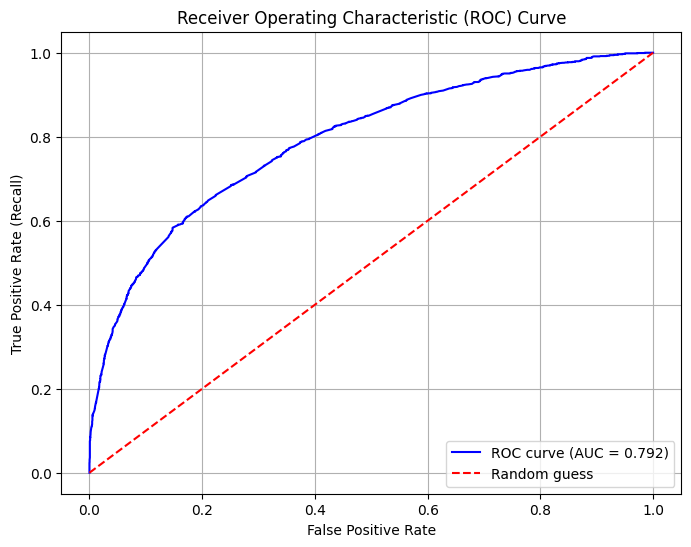

In [43]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The ROC-AUC score of 0.79 indicates that the model maintains strong overall discriminatory power across different decision thresholds. This suggests that the model is reliable and flexible, allowing decision-makers to adjust the threshold depending on campaign goals, budget constraints, and operational capacity.

Overall, these results demonstrate that the model is better suited for real-world marketing use when evaluated through a business-oriented lens rather than relying solely on accuracy.

## 8. Project Conclusion and Recommendations

This project aimed to identify customers who are likely to purchase organic products, using historical loyalty-programme data and supervised machine learning techniques. The target variable was a binary indicator of organic product purchase (ORGYN), and the analysis focused on building a model that is both predictive and aligned with real business objectives.

A structured data preparation process was applied, including missing value handling, feature encoding, and the removal of redundant or highly correlated variables. Particular care was taken to prevent data leakage by embedding all preprocessing steps within modelling pipelines. Exploratory analysis and profiling highlighted strong correlations between several demographic variables, guiding informed feature selection decisions.

Three model families were evaluated: Random Forest, XGBoost, and a Neural Network. These models were chosen to provide a balanced comparison between ensemble methods, gradient boosting, and non-linear approaches. All models were trained using the same preprocessing pipeline and evaluated on a held-out test set to ensure a fair comparison. Hyperparameter tuning was performed using GridSearchCV to optimise performance.

Among the tested models, **XGBoost consistently achieved the best overall performance**, with the highest test accuracy and a strong ROC-AUC score of approximately 0.79. This indicates good separation between buyers and non-buyers and confirms that the model learned meaningful patterns in the data.

Given the class imbalance and the marketing nature of the problem, model evaluation focused not only on accuracy but also on precision and recall for organic buyers. Missing a potential buyer represents a higher business cost than contacting a non-buyer. For this reason, the classification threshold was adjusted from the default value of 0.5 to **0.4**, increasing recall to approximately 0.80 and substantially reducing false negatives. Although this led to more false positives, the trade-off was considered acceptable within the context of a low-cost marketing campaign.

The final recommended solution is therefore an **XGBoost model with tuned hyperparameters and a probability threshold of 0.4**, prioritising recall while maintaining reasonable overall performance. This model is suitable for deployment as a decision-support tool to guide targeted organic product promotions.
